In [1]:
from pathlib import Path
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from astropy import units
import glob

In [3]:
datapath = Path("../data/my_data/")

In [5]:
from utils import table_utils, header_utils, shared_utils, cat_utils

In [6]:
hdrs = header_utils.load_headers('pri')

In [8]:
# for i in hdrs.columns:
#     print(i)
# hdrs['PA_V3'].unique()

In [10]:
full_imgs_df = hdrs.query("subarray==False")

In [19]:
ff_hdr = full_imgs_df.loc[full_imgs_df.index[0]]
ff_hdr['filename']

'icct02jfq_flt.fits'

In [13]:
hdulist = fits.open(datapath / ff_hdr['filename'])
data = hdulist[1].data
hdulist.close()

In [15]:
# ROOTNAME is the unique file identifier
img_hdr = header_utils.load_headers('sci').query(f"rootname == '{ff_hdr['rootname']}'")

In [16]:
img_hdr

xtension  bitpix  naxis  naxis1  naxis2  pcount  gcount  \
7    IMAGE     -32      2    1014    1014       0       1   

                     origin        date  inherit  ... ctype2b  crval1b  \
7  HSTIO/CFITSIO March 2010  2019-12-30     True  ...     NaN      NaN   

  crval2b lonpoleb latpoleb  radesysb  cd1_1b  cd1_2b  cd2_1b  cd2_2b  
7     NaN      NaN      NaN       NaN     NaN     NaN     NaN     NaN  

[1 rows x 167 columns]

In [17]:
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.cmap'] = 'magma'

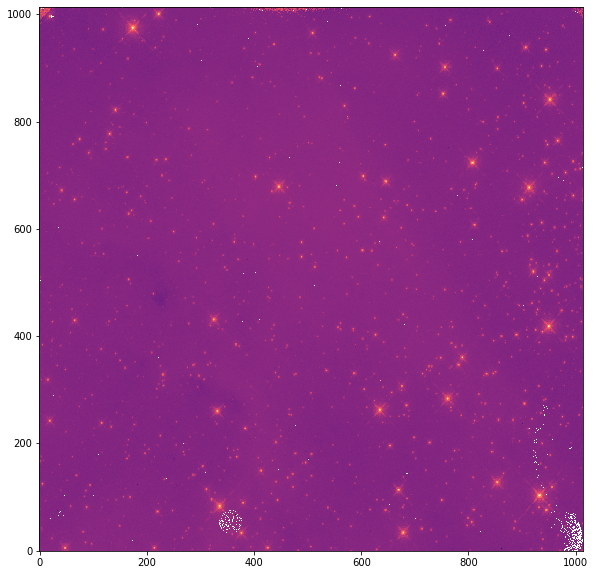

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(data, norm=mpl.colors.LogNorm())

# Load source finding packages

In [20]:
from astropy.stats import sigma_clipped_stats
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std)) 

(6.954757, 6.8444066, 1.1888484)


In [21]:
from photutils import DAOStarFinder, IRAFStarFinder, find_peaks

In [22]:
from astropy.visualization import SqrtStretch,  LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

## DAOStarFinder

In [39]:
daofind = DAOStarFinder(fwhm=1.5, threshold=500.*std)  
dao_sources = daofind(data - median).to_pandas()
print(dao_sources.shape)

(122, 11)


In [47]:
dao_sources

ps_img_id   xcentroid    ycentroid  sharpness  roundness1  roundness2  \
0            1   48.490171     5.277620   0.750470    0.193945   -0.058275   
1            2  214.885481     5.304711   0.843239    0.621880    0.513084   
2            3  426.011450     5.738847   0.940257    0.205818    0.197495   
3            4  938.912665    21.868278   0.967699    0.117607    0.033535   
4            5  376.945645    33.192733   0.960539    0.186389    0.179906   
..         ...         ...          ...        ...         ...         ...   
117        118  174.405296   974.627308   0.680945    0.336747    0.095103   
118        119  766.523558   989.069960   0.894302   -0.287815   -0.246869   
119        120   19.693113   996.815324   0.933544    0.175740   -0.047207   
120        121  222.515035  1000.922379   0.907950   -0.131800   -0.266999   
121        122  435.371901  1012.861983   0.902565   -0.727626   -0.707707   

     npix  sky          peak       flux       mag  
0      25  0.0   6384.422852   9.429433 -2.436214  
1      25  0.0   3105.113281   4.642771 -1.666943  
2      25  0.0   5494.625977   7.969020 -2.253512  
3      25  0.0    700.102905   1.009939 -0.010738  
4      25  0.0  16532.482422  24.030271 -3.451897  
..    ...  ...           ...        ...       ...  
117    25  0.0  37279.414062  50.701127 -4.262544  
118    25  0.0    826.730408   1.217898 -0.214027  
119    25  0.0   6067.810059   8.721654 -2.351497  
120    25  0.0  16958.214844  24.846526 -3.488164  
121    25  0.0    775.606995   1.150578 -0.152290  

[122 rows x 11 columns]

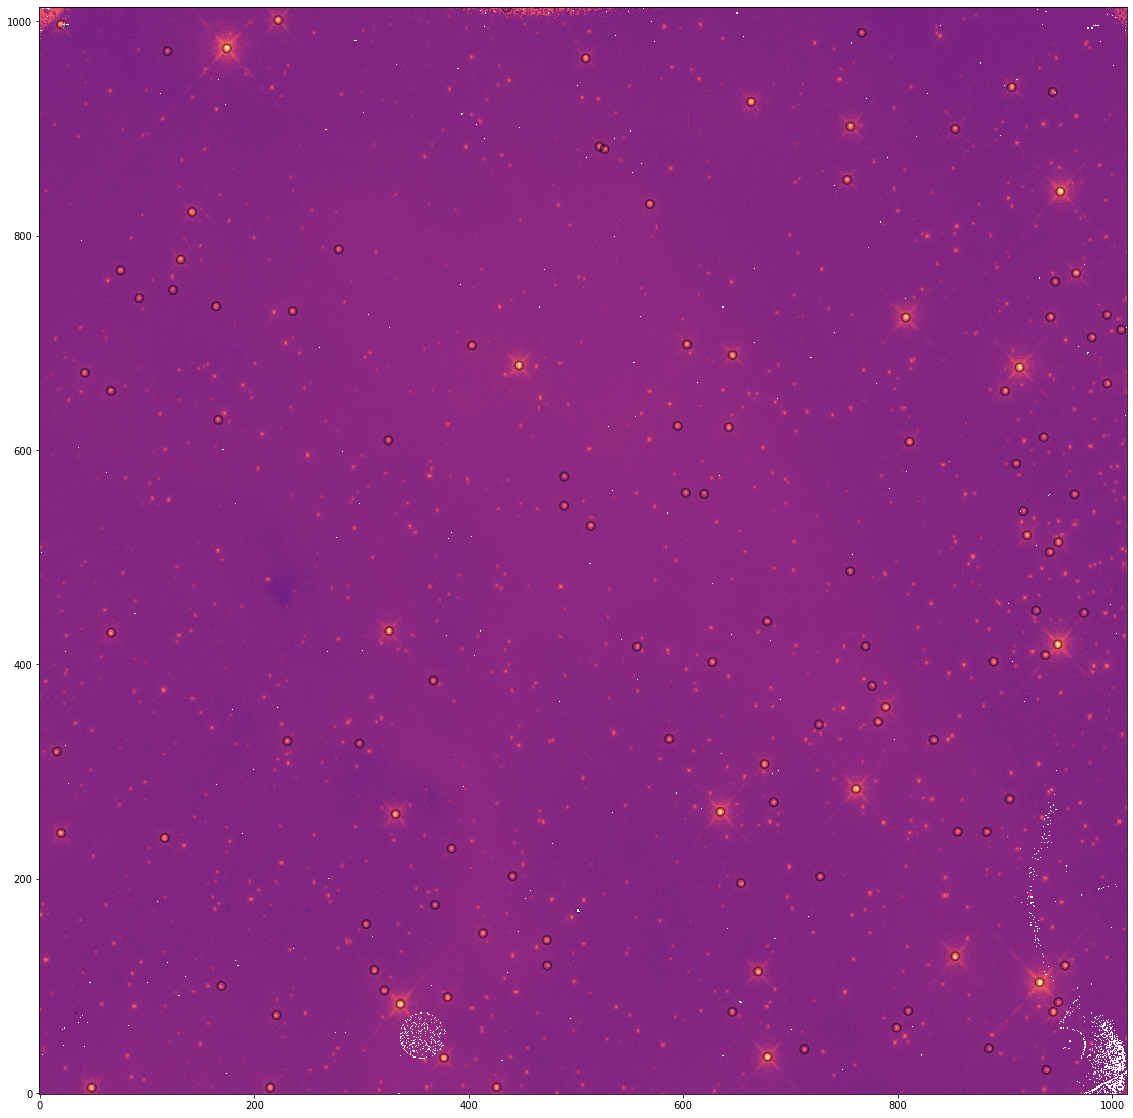

In [40]:
positions = np.transpose((dao_sources['xcentroid'], dao_sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)

## IRAFStarFinder

In [27]:
iraffind = IRAFStarFinder(fwhm=1.5, threshold=100.*std)  
iraf_sources = iraffind(data - median).to_pandas()
print(iraf_sources.shape)

(462, 12)


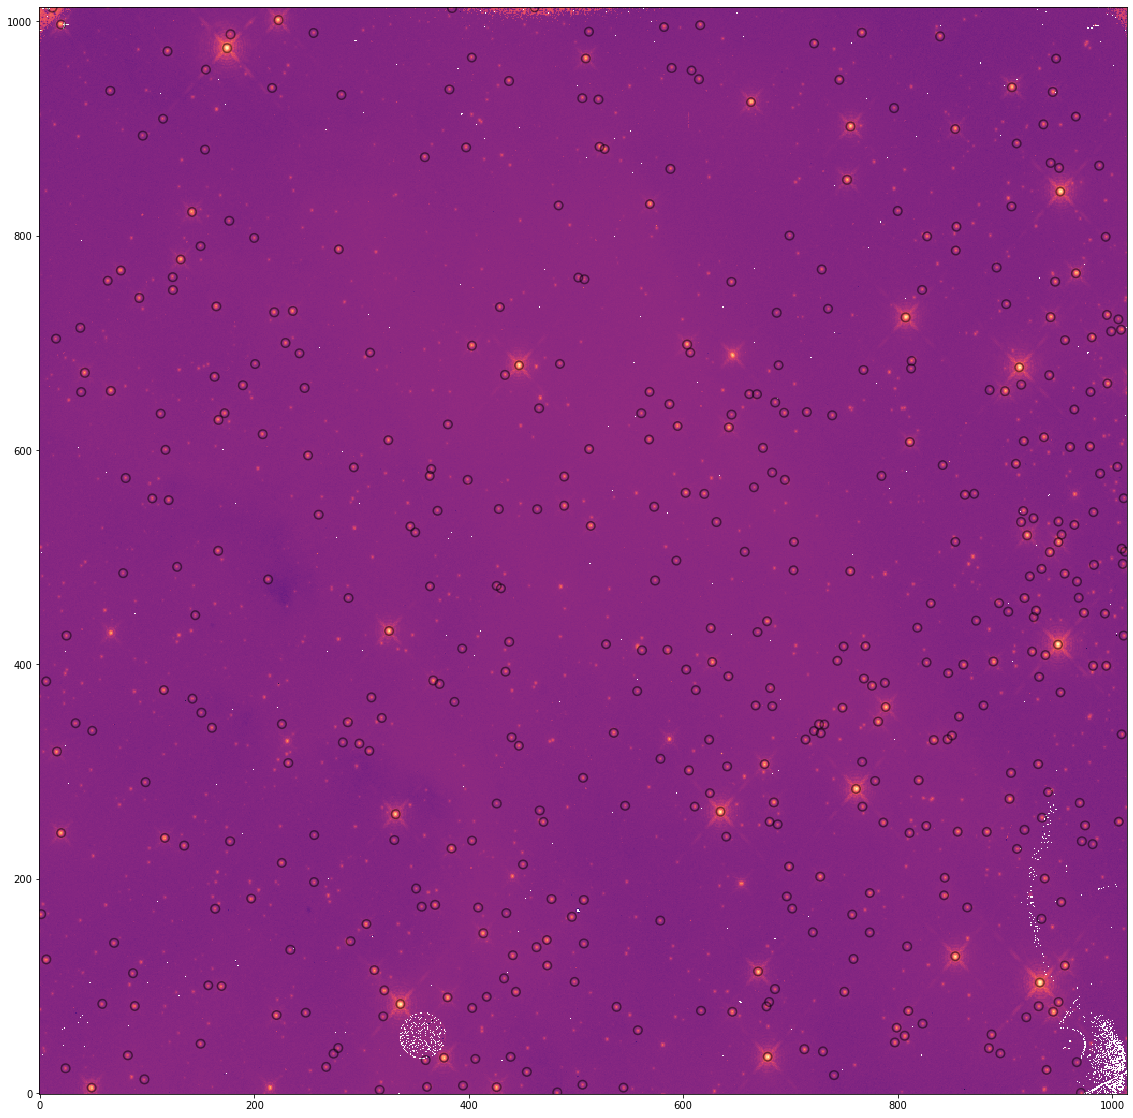

In [28]:
positions = np.transpose((iraf_sources['xcentroid'], iraf_sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)

## find_peaks()

In [32]:
threshold = median + (100. * std)
fp_sources = find_peaks(data, threshold, box_size=11)
fp_sources['peak_value'].info.format = '%.8g'  # for consistent table output
print(len(fp_sources))  # print only the first 10 peaks

559


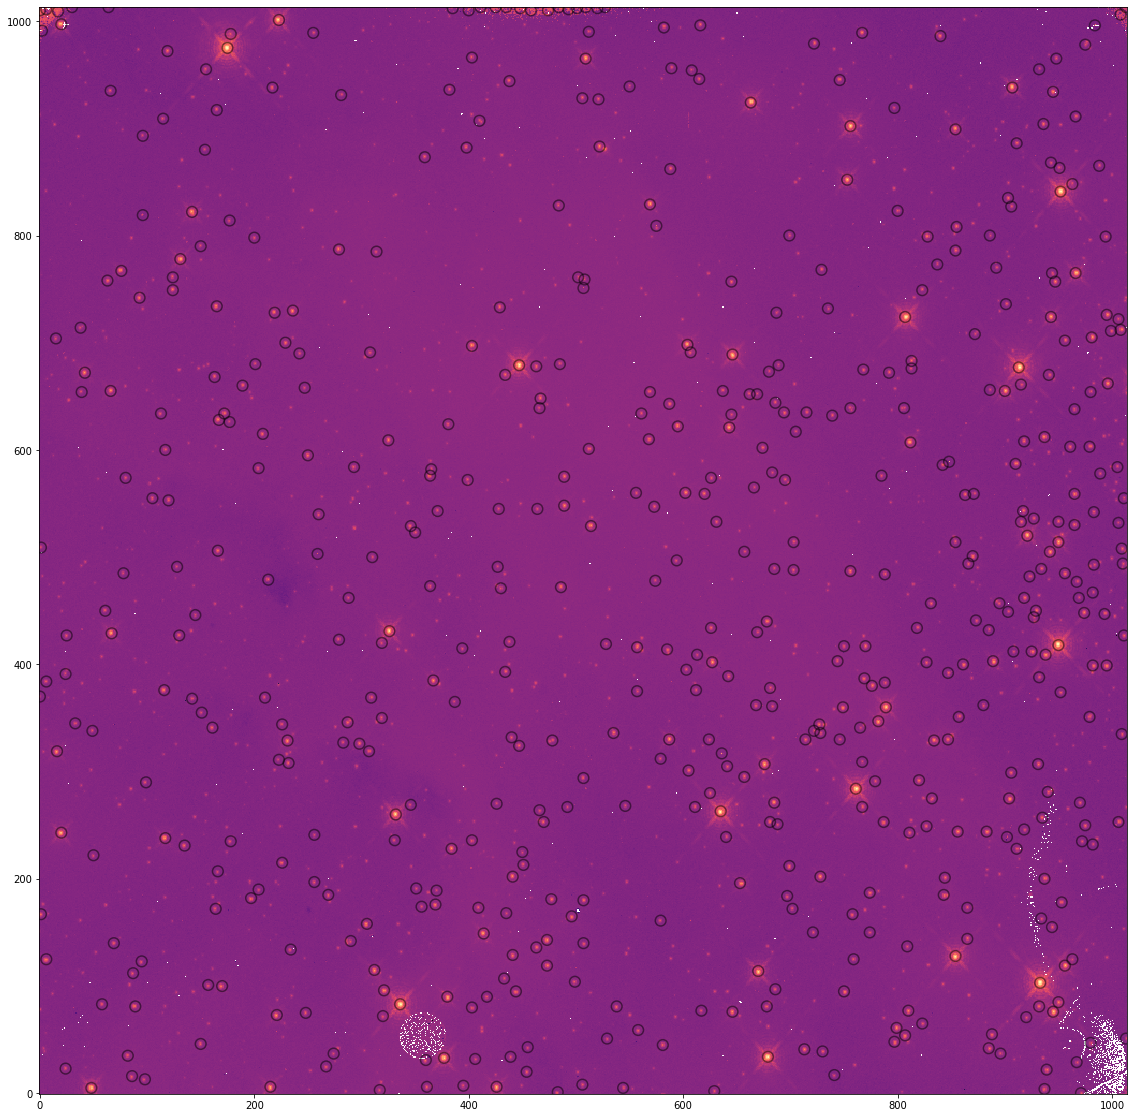

In [33]:
positions = np.transpose((fp_sources['x_peak'], fp_sources['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = ImageNormalize(stretch=LogStretch())
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(data, origin='lower', norm=mpl.colors.LogNorm())
apertures.plot(color='k', lw=1.5, alpha=0.5)

# Test file for mapping to RA and Dec

In [34]:
# dao stars
dao_sources;
# iraf stars
iraf_sources;
# find_peak stars
fp_sources;

'icct02jfq'

In [41]:
dao_sources.to_csv(f"../data/tables/dao_sources_{ff_hdr['rootname']}.csv")